In [2]:
print(__doc__)

# Author: Zehui Li
# Time 2018/11/01

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_rand_score
from tqdm import tqdm
import math

Automatically created module for IPython interactive environment


### Generate Data

In [14]:
# Generate 3 blobs with 2 classes where the second blob 
# Cluster_std is the standard deviation, random_state is used for reproduce the experiment 
n_samples = 100
centers = [(-5, -5), (0, 0), (5, 5),(10,-3)]
X, y = make_blobs(n_samples=n_samples, n_features=2, cluster_std=2,
                  centers=centers, shuffle=True)

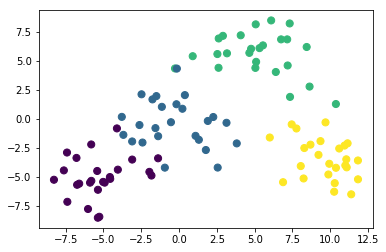

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(X[:,0],X[:,1],c=y,s=50)

#### Create a sample Matrix from 2-d data

In [16]:
from scipy.spatial.distance import euclidean, pdist, squareform

data = X
def similarity_func(u, v):
    return euclidean(u,v)

DF_var = pd.DataFrame.from_dict(data)
dists = pdist(DF_var, similarity_func)
dist_matric = squareform(dists)

#### K medoid

In [25]:
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import cluster_visualizer;
from pyclustering.utils import timedcall;
def convert_pycluster_to_sklearn(pycluster_input):
    result = np.zeros(len([j for i in pycluster_input for j in i]))
    for i,myInd in np.ndenumerate(pycluster_input):
        result[myInd] = i[0]
    return result
def kmediod_tester(dist_matrix):
    kmedoids_instance = kmedoids(dist_matrix, [1,2,3,4], 0.25,data_type='distance_matrix');
    (ticks, result) = timedcall(kmedoids_instance.process);
    clusters = kmedoids_instance.get_clusters();
    return convert_pycluster_to_sklearn(clusters)

### Single linkage

In [20]:
from sklearn.cluster import AgglomerativeClustering
def single_linkage_tester(dist_matrix):
    model = AgglomerativeClustering(affinity='precomputed', n_clusters=3, linkage='complete').fit(dist_matrix)
    return model.labels_

### Perburbation function definition

In [21]:
import random
from math import factorial
# take the similarity matrix, partition result
# and ramdom_seed (which is used to reproduce the experiment)
def perturb_distance_matrix(in_matrix,partition,random_seed):
    matrix = np.matrix.copy(in_matrix)
    #take the index of first,second ... cluster
    partition_list = list()
    for i in np.unique(partition):
        index_i = np.where(partition==i)
        if len(index_i[0])!=1:
            #In one cluster: Randomly select the x pair of points
            temp_upper_bound = factorial(len(index_i[0]))/(factorial(len(index_i[0])-2)*2)
            loop_time = random.randint(1,temp_upper_bound+1)
            #Randomly reduce the distance between each pair
            for j in range(1,loop_time+1):
                pair = np.random.choice(index_i[0],2,False)
                matrix[pair[0],pair[1]]=  matrix[pair[1],pair[0]]= random.uniform(0, 1)*matrix[pair[1],pair[0]]
            #store the partition into the list
        partition_list.append(index_i[0])
    #Ramdonmly select x' pair of clusters
    temp_upper_bound = factorial(len(partition_list))/(factorial(len(partition_list)-2)*2)
    loop_time = random.randint(1,temp_upper_bound+1)
    #increate the distance between clusters with a random ratio
    for i in range(1,loop_time+1):
        cluster_pair = random.sample(partition_list,2)
        #create a ramdom generated matrix - then do elementwise multiplication
        increase_coefficient = np.multiply((np.random.rand(cluster_pair[0].shape[0],cluster_pair[1].shape[0])+1),(np.random.randint(4,size=(cluster_pair[0].shape[0],cluster_pair[1].shape[0]))+1))
        temp_multiplier = np.multiply(matrix[np.ix_(cluster_pair[0],cluster_pair[1])],increase_coefficient)
        matrix[np.ix_(cluster_pair[0],cluster_pair[1])]= temp_multiplier
       # the points are symmetric to each other, so do the corresponding changes
        matrix[np.ix_(cluster_pair[1],cluster_pair[0])] = np.matrix.transpose(temp_multiplier)

    return matrix

### Classification(Kmdeoid)
#### Gnerate the dataset

In [30]:
from sklearn import preprocessing
def upperTri(ele):   
    #this function produce a matrix with upper triangle equals 1 and other element equals -1
    dimention = int(math.sqrt(ele.shape[0]))
    result = np.ones((dimention, dimention))*(-1)
    result = np.matrix(result).A1
    for i in range(1,dimention):
        for j in range(i,dimention):
            my_index = (i-1)*dimention + j
            result[my_index] = 1
    return result
def select_attributes(input_features):
    help_matrix = upperTri(input_features[0])
    temp_features = [(help_matrix*ele) for ele in input_features]
    return [ele[ele>=0] for ele in temp_features]


def generate_data_help(num_iter=3000,label_threshold=0.8):
    re_matrix_list = []
    rand_score_array = np.zeros(num_iter)
    for i in tqdm(range(0,num_iter)):
        dist_matrix=dist_matric
        partition = kmediod_tester(dist_matrix)
        dist_matric2 = perturb_distance_matrix(dist_matric,partition,1)
        re_matrix_list.append(dist_matric2)
        partition2 = kmediod_tester(dist_matric2)
        rand_score_array[i]=adjusted_rand_score(partition,partition2)
    labels = (rand_score_array>=label_threshold).astype(int)
    features = [np.matrix(ele).A1 for ele in re_matrix_list]
    reduced_features = select_attributes(features)
    return reduced_features,labels
def generate_data(num_iter=3000,label_threshold=0.8):
    reduced_features,labels = generate_data_help(num_iter,label_threshold)
    standardized_reduced_features = preprocessing.scale(reduced_features)
    return standardized_reduced_features,labels

In [ ]:
X_test, y_test = generate_data(label_threshold=1)

In [60]:
listSvmModel = []
listSvmAccuracy = []

listDecisionTree = []
listDecisionTreeAccu = []

listRandomForest = []
listRandomForestAccu = []
for i in range(1,20):
    features,labels = generate_data(10000*i,1)
    #SVM 
    #Training
    clfSVM = SVC(gamma='auto')
    clfSVM.fit(features,labels)
    listSvmModel.append(clfSVM)
    #Evaluation
    listSvmAccuracy.append(clfSVM.score(X_test,y_test))
    
    #DecisionTree
    #Training
    clf_tree = tree.DecisionTreeClassifier()
    clf_tree = clf_tree.fit(features,labels)
    listDecisionTree.append(clf_tree)
    #Evaluation
    listDecisionTreeAccu.append(clf_tree.score(X_test,y_test))
    
    #Random Forest
    #training
    clf_rf= RandomForestClassifier()
    clf_rf=clf_rf.fit(features,labels)
    listRandomForest.append(clf_rf)
    #Evaluation
    listRandomForestAccu.append(clf_rf.score(X_test,y_test))

100%|██████████| 10000/10000 [05:48<00:00, 28.66it/s]
C:\Users\ljh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
100%|██████████| 20000/20000 [09:45<00:00, 34.18it/s]
C:\Users\ljh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
100%|██████████| 30000/30000 [14:38<00:00, 34.15it/s]
C:\Users\ljh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
100%|██████████| 40000/40000 [20:42<00:00, 30.08it/s]
C:\Users\ljh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The defau

KeyboardInterrupt: 

 44%|████▍     | 26552/60000 [15:30<19:26, 28.66it/s]

In [86]:
np.arange(1,6,1)

array([1, 2, 3, 4, 5])

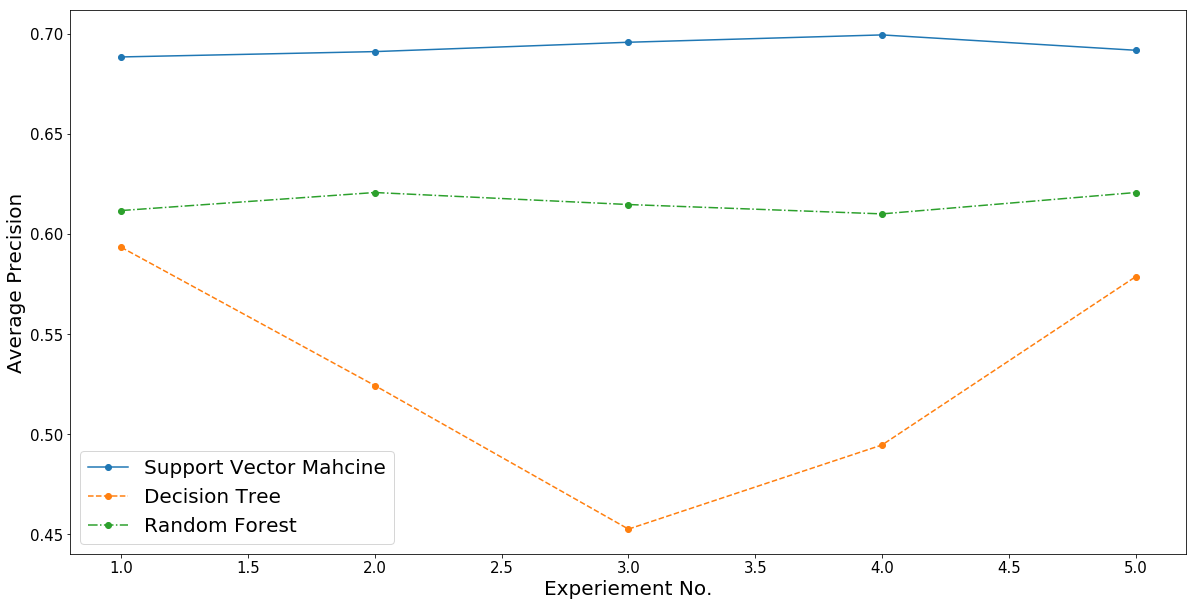

In [105]:
fig,ax1=plt.subplots(1,1,figsize=(20,10))
x = np.arange(1,6,1)

plt.plot(x, np.array(listSvmAccuracy),"-o",label="Support Vector Mahcine")
plt.plot(x, np.array(listDecisionTreeAccu),"--o",label="Decision Tree")
plt.plot(x, np.array(listRandomForestAccu),"-.o",label="Random Forest")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.xlabel('Experiement No.', fontsize=20)
plt.ylabel('Average Precision',fontsize=20)
plt.tick_params(labelsize=15)
ax1.legend(fontsize=20)
plt.savefig('posterDiscussion.png')

In [61]:
listSvmAccuracy

[0.6883333333333334,
 0.691,
 0.6956666666666667,
 0.6993333333333334,
 0.6916666666666667]

In [62]:
listDecisionTreeAccu

[0.5933333333333334,
 0.5243333333333333,
 0.45266666666666666,
 0.49466666666666664,
 0.5786666666666667]

In [63]:
listRandomForestAccu

[0.6116666666666667,
 0.6206666666666667,
 0.6146666666666667,
 0.61,
 0.6206666666666667]

In [64]:
for i in range(0,6):
    print("SVM")
    y_true = y_test
    y_pred = listSvmModel[i].predict(X_test)
    target_names = ['class 0', 'class 1']
    print(classification_report(y_true, y_pred, target_names=target_names))
    print("Decesion Tree")
    y_true = y_test
    y_pred = listDecisionTree[i].predict(X_test)
    target_names = ['class 0', 'class 1']
    print(classification_report(y_true, y_pred, target_names=target_names))
    print("Random Forest")
    y_true = y_test
    y_pred = listRandomForest[i].predict(X_test)
    target_names = ['class 0', 'class 1']
    print(classification_report(y_true, y_pred, target_names=target_names))


SVM
              precision    recall  f1-score   support

     class 0       0.69      0.93      0.79      1947
     class 1       0.65      0.25      0.36      1053

   micro avg       0.69      0.69      0.69      3000
   macro avg       0.67      0.59      0.58      3000
weighted avg       0.68      0.69      0.64      3000

Decesion Tree
              precision    recall  f1-score   support

     class 0       0.68      0.70      0.69      1947
     class 1       0.42      0.40      0.41      1053

   micro avg       0.59      0.59      0.59      3000
   macro avg       0.55      0.55      0.55      3000
weighted avg       0.59      0.59      0.59      3000

Random Forest
              precision    recall  f1-score   support

     class 0       0.69      0.74      0.71      1947
     class 1       0.44      0.38      0.40      1053

   micro avg       0.61      0.61      0.61      3000
   macro avg       0.56      0.56      0.56      3000
weighted avg       0.60      0.61      0.6

IndexError: list index out of range

#### SVM
##### Train the model

In [53]:
from sklearn.svm import SVC
clfSVM = SVC(gamma='auto')
clfSVM.fit(features1,labels1)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Decision Tree
##### Train the model

In [56]:
from sklearn import tree
clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(features1,labels1)

#### Random Forest
##### Train the model

In [57]:
from sklearn.ensemble import RandomForestClassifier

clf_rf= RandomForestClassifier()
clf_rf=clf_rf.fit(features1,labels1)

C:\Users\ljh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Measure the performance

In [38]:
from sklearn.metrics import classification_report

#### SVM

In [54]:
y_true = y_test
y_pred = clfSVM.predict(X_test)
target_names = ['class 0', 'class 1']
print(classification_report(y_true, y_pred, target_names=target_names))
print(clfSVM.score(X_test, y_test))

              precision    recall  f1-score   support

     class 0       0.71      0.90      0.79      1947
     class 1       0.63      0.33      0.43      1053

   micro avg       0.70      0.70      0.70      3000
   macro avg       0.67      0.61      0.61      3000
weighted avg       0.68      0.70      0.67      3000

0.697


#### Decision Tree

In [58]:
y_true = y_test
y_pred = clf_tree.predict(X_test)
target_names = ['class 0', 'class 1']
print(classification_report(y_true, y_pred, target_names=target_names))
print(clf_tree.score(X_test, y_test))

              precision    recall  f1-score   support

     class 0       0.65      0.56      0.60      1947
     class 1       0.35      0.43      0.39      1053

   micro avg       0.52      0.52      0.52      3000
   macro avg       0.50      0.50      0.49      3000
weighted avg       0.54      0.52      0.53      3000

0.518


#### Random forest

In [59]:
y_true = y_test
y_pred = clf_rf.predict(X_test)
target_names = ['class 0', 'class 1']
print(classification_report(y_true, y_pred, target_names=target_names))
print(clf_rf.score(X_test, y_test))

              precision    recall  f1-score   support

     class 0       0.68      0.83      0.74      1947
     class 1       0.46      0.27      0.34      1053

   micro avg       0.63      0.63      0.63      3000
   macro avg       0.57      0.55      0.54      3000
weighted avg       0.60      0.63      0.60      3000

0.6316666666666667
